# Daily Sunshine App NLP Model

## Objective of this Notebook
To create a NLP Model that classifies a given piece of plaintext into two categories, Good or Bad. The output of the model will be presented as a floating point numeral. This numeral will help us interpret the decision.

## Notebook Plan

- Multiple models will be created for each of the following datasets as training input
  - [IMDb Movie Reviews Dataset](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)
  - [Financial Phrase Bank Dataset](https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news)
  - [Positive and Negative Word List](https://www.kaggle.com/datasets/mukulkirti/positive-and-negative-word-listrar)
  - [News Sentiment Dataset](https://www.kaggle.com/datasets/hoshi7/news-sentiment-dataset)

- All the above models will be tested on 
  - New Data points from the newsapi.org API
  - ["All the News" Dataset](https://www.kaggle.com/datasets/snapcrack/all-the-news)
  - ["Million News Headlines" Dataset](https://www.kaggle.com/datasets/therohk/million-headlines)
  

In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.12.*"
!pip install -q tf-models-official==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 18.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 88.2 MB/s eta 0:00:00


In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
def build_classifier_model(preprocess, encoder):
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

## Evaluation Datasets

### "All the News" Dataset

In [4]:
!cp "/content/drive/MyDrive/Colab Notebooks/Daily Sunshine App/data/all_the_news.csv" "/content/all_the_news.csv"

In [5]:
atn_dataframe = pd.read_csv('all_the_news.csv', encoding = 'utf-8', encoding_errors = 'ignore')

In [6]:
atn_dataframe.drop(atn_dataframe.iloc[:, 3:], inplace=True, axis=1)
atn_dataframe.drop(atn_dataframe.iloc[:, :2], inplace=True, axis=1)
atn_dataframe

,title
0,House Republicans Fret About Winning Their Hea...
1,Rift Between Officers and Residents as Killing...
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ..."
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi..."
4,Kim Jong-un Says North Korea Is Preparing to T...
...,...
49995,"Rex Tillerson Says Climate Change Is Real, but …"
49996,The Biggest Intelligence Questions Raised by t...
49997,Trump Announces Plan That Does Little to Resol...
49998,Dozens of For-Profit Colleges Could Soon Close


In [7]:
def atn_array(n = 10):
  return np.squeeze(atn_dataframe.sample(n=n).values)

In [8]:
atn_array(20)

array(['Civil Rights Commission Launches Investigation into Trump Admin. - Breitbart',
       'And, Scene: American Honey',
       'Nobel economist: One-percenters, pay your taxes',
       'Kanye West Bodyguard Reveals Infantile Behavior: ’So Much Easier’ to Babysit His Daughter - Breitbart',
       'Number of Five to Eleven Year Olds Suspended for ’Racism’ Up 33 Per Cent',
       'Tom Brady on Trump: ’I’ve Always Had a Good Time With Him’ - Breitbart',
       '13,000 people hanged in secret at Syrian prison, Amnesty says  ',
       'Men’s clothing stores keep popping up in New York City — and they’re all targeting the same kind of guy',
       'Pro-choice? You might also be pro-gun.',
       'A Suburban Experiment Aims for Free Energy - The New York Times',
       'Police: Man Finds Nude Photos of His 10-Year-Old Sister on Neighbor’s Laptop',
       'Hillary Clinton’s Vast Right-Wing Conspiracies, Versions 1.0, 2.0 and 3.0 - Breitbart',
       'Flashback: Rev. Jesse Jackson Praises Tr

### Million News Headlines Dataset

In [9]:
!cp "/content/drive/MyDrive/Colab Notebooks/Daily Sunshine App/data/million_news_headlines.csv" "/content/million_news_headlines.csv"

In [10]:
mnh_dataframe = pd.read_csv('million_news_headlines.csv', encoding = 'utf-8', encoding_errors = 'ignore')
mnh_dataframe

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers
...,...,...
1244179,20211231,two aged care residents die as state records 2...
1244180,20211231,victoria records 5;919 new cases and seven deaths
1244181,20211231,wa delays adopting new close contact definition
1244182,20211231,western ringtail possums found badly dehydrate...


In [11]:
mnh_dataframe.drop(mnh_dataframe.iloc[:, 0:1], inplace=True, axis=1)
mnh_dataframe

,headline_text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers
...,...
1244179,two aged care residents die as state records 2...
1244180,victoria records 5;919 new cases and seven deaths
1244181,wa delays adopting new close contact definition
1244182,western ringtail possums found badly dehydrate...


In [12]:
def mnh_array(n = 10):
  return np.squeeze(mnh_dataframe.sample(n=n).values)

In [13]:
mnh_array(20)

array(['malcolm turnbull unveils new ministry',
       'pga says a sheep export permit needs to be appoved',
       'severe storm sweeps victoria',
       'royal commission into child sex abuse apologies not enough',
       'interview ryan stigg', 'endurance horse ride tom quilty',
       'clarke; siddle resume aussie innings',
       'confusion over el zorro entitlements',
       'government did not consult social media companies before law',
       'man jailed over ecstasy stash',
       'eurovision 2017 australian contestant revealed isaiah firebrace',
       'dokic through to second round in hobart',
       'shares rise on wall street gains',
       'snedeker wins torrey pines play off', 'interview john daly',
       'rates rise fails to slow consumer spending',
       'broken hill police disappointed with partygoers',
       'mine safety australia', 'bartlett ends hunger strike',
       'tuna quota cuts take toll on workers'], dtype=object)

In [14]:
# Fixed Dataset for comparing models

eval_data = np.concatenate([atn_array(100), mnh_array(100)], 0)

In [15]:
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

## Model I - IMDb Movie Review Dataset

### Downloading the Dataset

In [16]:
imdb_url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

imdb_dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', imdb_url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

imdb_dataset_dir = os.path.join(os.path.dirname(imdb_dataset), 'aclImdb')

imdb_train_dir = os.path.join(imdb_dataset_dir, 'train')

84125825/84125825 [==============================] - 8s 0us/step


In [17]:
# Remove unused folders to make it easier to load the data
imdb_remove_dir = os.path.join(imdb_train_dir, 'unsup')
shutil.rmtree(imdb_remove_dir)

### Split the Data into Training, Testing & Validation sets

In [18]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

imdb_raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

imdb_class_names = imdb_raw_train_ds.class_names
imdb_train_ds = imdb_raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

imdb_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

imdb_val_ds = imdb_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

imdb_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

imdb_test_ds = imdb_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


### Visualise the data

In [19]:
for text_batch, label_batch in imdb_train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({imdb_class_names[label]})\n')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)

Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as the

### Selecting a Model

In [20]:
#@title Choose a BERT model to fine-tune for IMDb Model

imdb_bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]


imdb_tfhub_handle_encoder = map_name_to_handle[imdb_bert_model_name]
imdb_tfhub_handle_preprocess = map_model_to_preprocess[imdb_bert_model_name]

print(f'BERT model selected           : {imdb_tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {imdb_tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


### Preprocessing Model

In [21]:
imdb_bert_preprocess_model = hub.KerasLayer(imdb_tfhub_handle_preprocess)

### Using the BERT Model

In [22]:
imdb_bert_model = hub.KerasLayer(imdb_tfhub_handle_encoder)

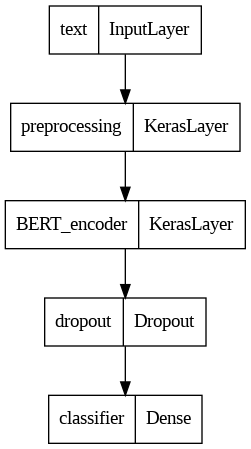

In [23]:
imdb_classifier_model = build_classifier_model(imdb_tfhub_handle_preprocess, imdb_tfhub_handle_encoder)
tf.keras.utils.plot_model(imdb_classifier_model)

In [24]:
imdb_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
imdb_metrics = tf.metrics.BinaryAccuracy()

imdb_epochs = 5
imdb_steps_per_epoch = tf.data.experimental.cardinality(imdb_train_ds).numpy()
imdb_num_train_steps = imdb_steps_per_epoch * imdb_epochs
imdb_num_warmup_steps = int(0.1*imdb_num_train_steps)

imdb_init_lr = 3e-5
imdb_optimizer = optimization.create_optimizer(init_lr=imdb_init_lr,
                                          num_train_steps=imdb_num_train_steps,
                                          num_warmup_steps=imdb_num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
imdb_classifier_model.compile(optimizer=imdb_optimizer,
                         loss=imdb_loss,
                         metrics=imdb_metrics)

imdb_history = imdb_classifier_model.fit(x=imdb_train_ds,
                               validation_data=imdb_val_ds,
                               epochs=imdb_epochs)

Epoch 1/5
337/625 [===============>..............] - ETA: 1:10 - loss: 0.5508 - binary_accuracy: 0.6878

### Evaluating the Model

In [ ]:
imdb_loss, imdb_accuracy = imdb_classifier_model.evaluate(imdb_test_ds)

print(f'Loss: {imdb_loss}')
print(f'Accuracy: {imdb_accuracy}')

In [ ]:
imdb_history_dict = imdb_history.history
print(imdb_history_dict.keys())

imdb_acc = imdb_history_dict['binary_accuracy']
imdb_val_acc = imdb_history_dict['val_binary_accuracy']
imdb_loss = imdb_history_dict['loss']
imdb_val_loss = imdb_history_dict['val_loss']

imdb_epochs = range(1, len(imdb_acc) + 1)
imdb_fig = plt.figure(figsize=(10, 6))
imdb_fig.tight_layout()

plt.subplot(2, 1, 1)

plt.plot(imdb_epochs, imdb_loss, 'r', label='Training loss')

plt.plot(imdb_epochs, imdb_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(imdb_epochs, imdb_acc, 'r', label='Training acc')
plt.plot(imdb_epochs, imdb_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

### Make Predictions

In [ ]:
# imdb_eval_data = np.concatenate([atn_array(30), mnh_array(30)], 0)
imdb_df = pd.DataFrame(np.squeeze(imdb_classifier_model.predict(eval_data)))
imdb_df.insert(1, "Title", eval_data, True)
imdb_df

## Model II - Financial Phrase Bank Dataset

### Downloading the Dataset

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/Daily Sunshine App/data/financial_phrase_bank.csv" "/content/financial_phrase_bank.csv"

In [ ]:
fpb_dataframe = pd.read_csv('financial_phrase_bank.csv', encoding = 'utf-8', encoding_errors = 'ignore', names = ('Tone', 'Headline'))
fpb_dataframe = fpb_dataframe[fpb_dataframe['Tone'] != 'neutral']
fpb_dataframe

In [ ]:
!rm -rf financial_phrase_bank

In [ ]:
fpb_dataset_dir = 'financial_phrase_bank'

os.mkdir(fpb_dataset_dir)

fpb_train_dir = os.path.join(fpb_dataset_dir, 'train')
fpb_test_dir = os.path.join(fpb_dataset_dir, 'test')

os.mkdir(fpb_train_dir)
os.mkdir(fpb_test_dir)

for path in [fpb_train_dir, fpb_test_dir]:
  os.mkdir(os.path.join(path, 'negative'))
  os.mkdir(os.path.join(path, 'positive'))


count_train = 1
count_test = 1

# Training Dataset
for ind in fpb_dataframe[int(.7*len(fpb_dataframe)):].index:
  with open(os.path.join(fpb_train_dir,  fpb_dataframe['Tone'][ind], str(count_train)+'.txt'), 'w') as file_obj:
    file_obj.write(fpb_dataframe['Headline'][ind])
  count_train +=1

# Testing Dataset
for ind in fpb_dataframe[:int(.3*len(fpb_dataframe))].index:
  with open(os.path.join(fpb_test_dir,  fpb_dataframe['Tone'][ind], str(count_test)+'.txt'), 'w') as file_obj:
    file_obj.write(fpb_dataframe['Headline'][ind])
  count_test +=1

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

fpb_raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    fpb_train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

fpb_class_names = fpb_raw_train_ds.class_names
fpb_train_ds = fpb_raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

fpb_val_ds = tf.keras.utils.text_dataset_from_directory(
    fpb_train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

fpb_val_ds = fpb_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

fpb_test_ds = tf.keras.utils.text_dataset_from_directory(
    fpb_test_dir,
    batch_size=batch_size)

fpb_test_ds = fpb_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#@title Choose a BERT model to fine-tune for Financial Phrase Bank Model

fpb_bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]


fpb_tfhub_handle_encoder = map_name_to_handle[fpb_bert_model_name]
fpb_tfhub_handle_preprocess = map_model_to_preprocess[fpb_bert_model_name]

print(f'BERT model selected           : {fpb_tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {fpb_tfhub_handle_preprocess}')

In [ ]:
fpb_bert_preprocess_model = hub.KerasLayer(fpb_tfhub_handle_preprocess)

In [ ]:
fpb_bert_model = hub.KerasLayer(fpb_tfhub_handle_encoder)

In [ ]:
fpb_classifier_model = build_classifier_model(fpb_tfhub_handle_preprocess, fpb_tfhub_handle_encoder)
tf.keras.utils.plot_model(fpb_classifier_model)

In [ ]:
fpb_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
fpb_metrics = tf.metrics.BinaryAccuracy()

fpb_epochs = 10
fpb_steps_per_epoch = tf.data.experimental.cardinality(fpb_train_ds).numpy()
fpb_num_train_steps = fpb_steps_per_epoch * fpb_epochs
fpb_num_warmup_steps = int(0.1*fpb_num_train_steps)

fpb_init_lr = 3e-5
fpb_optimizer = optimization.create_optimizer(init_lr=fpb_init_lr,
                                          num_train_steps=fpb_num_train_steps,
                                          num_warmup_steps=fpb_num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
fpb_classifier_model.compile(optimizer=fpb_optimizer,
                         loss=fpb_loss,
                         metrics=fpb_metrics)

fpb_history = fpb_classifier_model.fit(x=fpb_train_ds,
                               validation_data=fpb_val_ds,
                               epochs=fpb_epochs)

In [ ]:
fpb_history_dict = fpb_history.history
print(fpb_history_dict.keys())

fpb_acc = fpb_history_dict['binary_accuracy']
fpb_val_acc = fpb_history_dict['val_binary_accuracy']
fpb_loss = fpb_history_dict['loss']
fpb_val_loss = fpb_history_dict['val_loss']

fpb_epochs = range(1, len(fpb_acc) + 1)
fpb_fig = plt.figure(figsize=(10, 6))
fpb_fig.tight_layout()

plt.subplot(2, 1, 1)

plt.plot(fpb_epochs, fpb_loss, 'r', label='Training loss')

plt.plot(fpb_epochs, fpb_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(fpb_epochs, fpb_acc, 'r', label='Training acc')
plt.plot(fpb_epochs, fpb_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [ ]:
# fpb_eval_data = np.concatenate([atn_array(100), mnh_array(100)], 0)
fpb_df = pd.DataFrame(np.squeeze(fpb_classifier_model.predict(eval_data)))
fpb_df.insert(1, "Title", eval_data, True)
fpb_df